<a href="https://colab.research.google.com/github/FreNzQuiN/GenerativeAI/blob/main/Stable_Diffusion/MyLatestInlineSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title #**1.1 START -- TEXT2IMG SD**
!pip install -q diffusers invisible_watermark transformers accelerate safetensors compel
import torch
from torch import autocast
from diffusers import StableDiffusionXLPipeline, DDIMScheduler #EulerAncestralDiscreteScheduler,
import json, os

if not os.path.exists("scheduler_config.json"):
  !wget https://huggingface.co/cagliostrolab/animagine-xl-4.0/resolve/main/scheduler/scheduler_config.json

custom_config = True #@param {type:'boolean'}
if os.path.exists("scheduler_config.json") and not custom_config:
  with open("scheduler_config.json", "r") as f:
    scheduler_config = json.load(f)
else:
  scheduler_config = {
    "beta_start": 0.00085,
    "beta_end": 0.012,
    "num_train_timesteps": 1000,
    "steps_offset" : 2,
    "beta_schedule": "scaled_linear",
    "clip_sample": False,
    "set_alpha_to_one": False,
    "_class_name": "DDIMScheduler",
    "_diffusers_version": "0.32.2"
  }

# model = "linaqruf/animagine-xl"
# pipe = StableDiffusionXLPipeline.from_pretrained(
#     model,
#     torch_dtype=torch.float16,
#     use_safetensors=True,
#     safety_checker = None,
#     requires_safety_checker = False,
#     variant="fp16",
#     )

pipe = StableDiffusionXLPipeline.from_pretrained(
    "cagliostrolab/animagine-xl-4.0",
    torch_dtype=torch.float16,
    use_safetensors=True,
    custom_pipeline="lpw_stable_diffusion_xl",
    add_watermarker=False,
    # variant="fp16",
    # device_map="auto",
    # cache_dir="/path/to/cache/directory", force_download=True,
    # low_cpu_mem_usage=True
    )

pipe.scheduler = DDIMScheduler.from_config(scheduler_config)
# pipe.scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
pipe.to('cuda')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.7 MB/s eta 0:00:00


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

--2025-03-16 02:07:48--  https://huggingface.co/cagliostrolab/animagine-xl-4.0/resolve/main/scheduler/scheduler_config.json
Resolving huggingface.co (huggingface.co)... 18.164.174.23, 18.164.174.17, 18.164.174.55, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 613 [text/plain]
Saving to: ‘scheduler_config.json’

scheduler_config.js 100%[===================>]     613  --.-KB/s    in 0s      

2025-03-16 02:07:48 (232 MB/s) - ‘scheduler_config.json’ saved [613/613]



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/671 [00:00<?, ?B/s]

lpw_stable_diffusion_xl.py:   0%|          | 0.00/106k [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/782 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

SDXLLongPromptWeightingPipeline {
  "_class_name": "SDXLLongPromptWeightingPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "cagliostrolab/animagine-xl-4.0",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
#@title #**1.2 START -- IMG2IMG SD**
from diffusers import StableDiffusionXLImg2ImgPipeline
from diffusers.utils import load_image

pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
pipe.to("cuda")
pipe.unet = torch.compile(pipe.unet, mode="reduce-overhead", fullgraph=True)

In [2]:
#@title #**2.1 PLAY TEXT2IMG SD**
num=0
prompt_num=0
def disabled_safety_checker(images, clip_input):
    if len(images.shape)==4:
        num_images = images.shape[0]
        return images, [False]*num_images
    else:
        return images, False
pipe.safety_checker = disabled_safety_checker
w = f"/content/outputs"
!mkdir {w}

Generating Images 38:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Generating Images 38:  12%|█▎        | 1/8 [00:41<04:47, 41.05s/it]

  0%|          | 0/28 [00:00<?, ?it/s]

Generating Images 38:  25%|██▌       | 2/8 [01:20<03:59, 39.92s/it]

  0%|          | 0/28 [00:00<?, ?it/s]

Generating Images 38:  38%|███▊      | 3/8 [01:59<03:19, 39.87s/it]

  0%|          | 0/28 [00:00<?, ?it/s]

Generating Images 38:  50%|█████     | 4/8 [02:39<02:39, 39.79s/it]

  0%|          | 0/28 [00:00<?, ?it/s]

Generating Images 38:  62%|██████▎   | 5/8 [03:19<01:58, 39.67s/it]

  0%|          | 0/28 [00:00<?, ?it/s]

Generating Images 38:  75%|███████▌  | 6/8 [03:58<01:19, 39.71s/it]

  0%|          | 0/28 [00:00<?, ?it/s]

Generating Images 38:  88%|████████▊ | 7/8 [04:38<00:39, 39.67s/it]

  0%|          | 0/28 [00:00<?, ?it/s]

Generating Images 38: 100%|██████████| 8/8 [05:17<00:00, 39.74s/it]


It took 5 minutes 17 seconds!


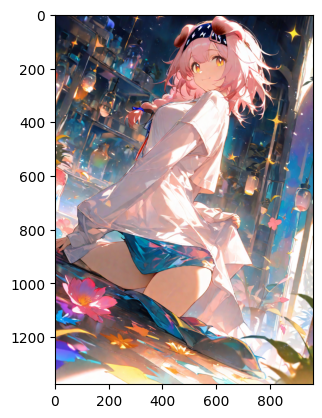

In [25]:
from compel import Compel, ReturnedEmbeddingsType
import matplotlib.pyplot as plt
from PIL import Image
import random, time, math, os
import torch, gc
from tqdm import tqdm

def generate_image(pipe, prompt, negative_prompt, output_path, width, height, guidance_scale, guidance_rescale, num_inference_steps, seed):
    """Menghasilkan gambar Stable Diffusion."""
    image = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        seed=seed,
        width=width,
        height=height,
        guidance_scale=guidance_scale,
        guidance_rescale=guidance_rescale,
        target_size=(width, height),
        original_size=(4096, 4096),
        num_inference_steps=num_inference_steps,
        truncation=True
    ).images[0]
    image.save(output_path)
    return image

def log_metadata(file_path, start_num, end_num, output_base, width, height, prompt, negative_prompt, guidance_scale, guidance_rescale, num_inference_steps, elapsed_time):
    """Mencatat metadata ke dalam file teks."""
    with open(file_path, "a") as text_file:
        text_file.write(f"\n\nTITLE: {start_num}--{end_num} {output_base} {width}x{height}px\n + {prompt}\n - {negative_prompt}\n guide scale/rescale: {guidance_scale}/{guidance_rescale}\n steps: {num_inference_steps}\nIt took {math.floor(elapsed_time/60)} minutes {math.floor(elapsed_time%60)} seconds!")


amount = 8 #@param {type:'integer'}
#@markdown ---
char = "(1girl, goldenglow (arknights), arknights (series))" #@param {type:"string"}
desc_char = "smirk, seducing expression, mature teen, casual outfit, glow star eyes, medium breast" #@param {type:'string'}
pov = "dutch angle, looking at viewer, from front, depth of field" # @param {"type":"string","placeholder":"dutch angle, looking at viewer, from front, depth of field, close up"}
bg = "colorful, indoors, natural scenery" #@param {type:"string"}
style = "smooth line, masterpiece, high score, absurdres, newest" #@param {type:"string"}
add = "[light particles]" #@param {type:"string"}
rating = "safe" # @param ["safe","sensitive"] {"allow-input":true}
#@markdown ---
prompt = f"{char}, {rating}, {desc_char}, {pov}, {bg}, {style}, {add}"
negative_prompt = "lowres, bad anatomy, bad hands, text, error, missing finger, extra digits, fewer digits, cropped, worst quality, low quality, low score, bad score, average score, signature, watermark, username, blurry, unnatural line" #@param {type:'string'}
#@markdown ---
W = 960 #@param {type:"slider", min:512, max:2048, step:32}
H = 1376 #@param {type:"slider", min:512, max:2048, step:32}
guidance_scale = 5 #@param {type:'number'}
guidance_rescale = 0.9 #@param {type:'number'}
num_inference_steps = 28 #@param {type:"slider", min:10, max:40, step:1}
#@markdown ---

if len(char)>10 and (char[:1]=="(" and char[-1:]==")"):
  nama_char = char.split(", ")[1].split(" ")[0]
  jenis_char = char.split(", ")[0][1:]
outputname = "anime" #@param {type:'string'}
outputbase = f"/content/outputs/{nama_char}/{outputname}_{jenis_char}"
w = f"/content/outputs/{nama_char}"
if not os.path.exists(w):
  !mkdir {w}
rand = True #@param {type:'boolean'}
if rand:
  seed = 9999999 #@param {type:'integer'}
startNum = num

start_time = time.time()
array_time = []

for x in tqdm(range(amount), desc=f"Generating Images {num}"):
    gc.collect()
    torch.cuda.empty_cache()
    image_start_time = time.time()
    if rand:
        set_seed = random.randint(100000, 100000000)
    else:
        set_seed = seed
    output_file = f"{outputbase}_{num}_{set_seed}_{rating}.png"
    image = generate_image(pipe, prompt, negative_prompt, output_file, W, H, guidance_scale, guidance_rescale, num_inference_steps, set_seed)
    plt.imshow(image[0])
    image_end_time = time.time()
    array_time.append(image_end_time - image_start_time)
    num += 1

end_time = time.time()
total_time = end_time - start_time
log_metadata(f"prompt{prompt_num}.txt", startNum, num - 1, outputbase, W, H, prompt, negative_prompt, guidance_scale, guidance_rescale, num_inference_steps, total_time)

gc.collect()
torch.cuda.empty_cache()

print(f"It took {math.floor(total_time/60)} minutes {math.floor(total_time%60)} seconds!")

In [ ]:
#@title +load_lora


lora_path = "/path/to/your/lora.safetensors"
pipe.load_lora_weights(lora_path)

In [ ]:
#@title #**2.2 PLAY IMG2IMG SD (COMINGSOON)**
url = ""
init_image = load_image(url).convert("RGB")
prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt, image=init_image).images

In [ ]:
!pip install numba
from numba import cuda
device = cuda.get_current_device()
device.reset()

In [ ]:
#@title # +**remove_file(s)**
!rm "/content/"*.png

In [ ]:
!rm f"/content/{outputbase}{num-1}_{setseed}.png"

In [27]:
#@title #**3.0 CONNECT & SAVE TO GOOGLE DRIVE**
from google.colab import drive
import datetime

drive.mount('/content/drive')

x = datetime.datetime.now().strftime("%Y_%m_%d")
!mkdir "/content/drive/MyDrive/Colab Notebooks/{x}"
!mkdir "/content/drive/MyDrive/Colab Notebooks/{x}/prompt{prompt_num}"

!mv "/content/outputs/" "/content/drive/MyDrive/Colab Notebooks/{x}/prompt{prompt_num}"
!mv "/content/"*.txt "/content/drive/MyDrive/Colab Notebooks/{x}/prompt{prompt_num}"

prompt_num = prompt_num + 1

Mounted at /content/drive


In [ ]:
!mv /content/dir {dir}

In [ ]:
!mkdir outputs

In [ ]:
!mv "/content/"*.png "/content/outputs"

In [ ]:
!smi-nvidia

In [ ]:
#@title #**4.0 AUTOMATE PROMPTING (COMINGSOON)**

class PromptStableDiffusion:
    def __init__(self, subjek, gaya, latar_belakang, detail_tambahan):
        self.subjek = subjek
        self.gaya = gaya
        self.latar_belakang = latar_belakang
        self.detail_tambahan = detail_tambahan

    def buat_prompt(self):
        prompt = f"{self.subjek}, {self.gaya}, latar belakang {self.latar_belakang}, {self.detail_tambahan}"
        return prompt

prompt1 = PromptStableDiffusion(
    subjek="seorang wanita muda",
    gaya="lukisan cat minyak impresionis",
    latar_belakang="taman bunga matahari yang luas",
    detail_tambahan="matahari terbenam, burung-burung terbang di kejauhan"
)

prompt2 = PromptStableDiffusion(
    subjek="seekor naga raksasa",
    gaya="fantasi gelap",
    latar_belakang="kastil kuno yang hancur",
    detail_tambahan="langit mendung, petir menyambar"
)

daftar_prompt = [prompt1, prompt2]

for prompt_obj in daftar_prompt:
    print(prompt_obj.buat_prompt())



import json
daftar_prompt_json = [prompt_obj.__dict__ for prompt_obj in daftar_prompt]

with open("prompt_stable_diffusion.json", "w") as f:
    json.dump(daftar_prompt_json, f, indent=4)

print("\nPrompt telah disimpan dalam file prompt_stable_diffusion.json")

# **0.0 *~ ARCHIVE*** ~

In [ ]:
#@markdown # Read Glosarium
!git clone https://github.com/FreNzQuiN/GenerativeAI/blob/main/Stable_Diffusion/cheatsheet.md

In [4]:
!pip show diffusers

Name: diffusers
Version: 0.32.2
Summary: State-of-the-art diffusion in PyTorch and JAX.
Home-page: https://github.com/huggingface/diffusers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/diffusers/graphs/contributors)
Author-email: diffusers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, huggingface-hub, importlib-metadata, numpy, Pillow, regex, requests, safetensors
Required-by: compel


In [ ]:
#@title #**2.1 PLAY TEXT2IMG SD**
from compel import Compel, ReturnedEmbeddingsType
import matplotlib.pyplot as plt
from PIL import Image
import random
import time
import math
import torch, gc

textFile = open(f"prompt{prompt_num}.txt", "a")

amount = 5 #@param {type:'integer'}
prompt = "1girl, goldenglow \(arknights\), arknights \(series\), dutch angle, looking at viewer, cgdct, cute, solo, smile, light particles, casual, beautiful background, blush, outdoors, park, medium breast, from front, depth of field, very smooth line, year 2024, masterpiece, high score, great score, absurdres" #@param {type:'string'}
negative_prompt = "lowres, bad anatomy, bad hands, text, error, missing finger, extra digits, fewer digits, cropped, worst quality, low quality, low score, bad score, average score, signature, watermark, username, blurry" #@param {type:'string'}
outputbase = "/content/anime_girl" #@param {type:'string'}
startNum = num

# compel = Compel(
#   tokenizer=[pipe.tokenizer, pipe.tokenizer_2] ,
#   text_encoder=[pipe.text_encoder, pipe.text_encoder_2],
#   returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED,
#   requires_pooled=[False, True]
# )
# conditioning, pooled = compel(prompt)
W = 1024 #@param {type:'integer'}
H = 1424 #@param {type:'integer'}
guidance_scale = 5 #@param {type:'number'}
guidance_rescale = 0.9 #@param {type:'number'}
num_inference_steps = 28 #@param {type:'integer'}
rand = True #@param {type:'boolean'}
start = time.time()
arrayTime = []

for x in range(amount):
  gc.collect()
  torch.cuda.empty_cache()
  start = time.time()
  if rand == True:
    setseed = random.randint(100000,10000000)
  else:
    seed = 6 #@param {type:'integer'}
    setseed = seed
  image = pipe(
      # prompt_embeds=conditioning, pooled_prompt_embeds=pooled,
      prompt=prompt,
      negative_prompt=negative_prompt,
      seed=setseed,
      width=W,
      height=H,
      guidance_scale=guidance_scale,
      guidance_rescale=guidance_rescale,
      target_size=(W,H),
      original_size=(4096,4096),
      num_inference_steps=num_inference_steps,
      truncation=True
      ).images[0]
  output=f"{outputbase}{num}_{setseed}.png"
  image.save(output)
  image = Image.open(output)
  plt.imshow(image)
  end = time.time()
  length = end - start
  arrayTime.append(length)
  num=num+1

end = time.time()
length = end - start
print("It took", math.floor(length/60), "minutes", math.floor(length%60), "seconds!")
textFile.write(f"\n\nTITLE: {startNum}--{num-1} {outputbase} {W}x{H}px\n + {prompt}\n - {negative_prompt}\n guide scale/rescale: {guidance_scale}/{guidance_rescale}\n steps: {num_inference_steps}\nIt took {math.floor(length/60)} minutes {math.floor(length%60)} seconds!")
textFile.close()
gc.collect()
torch.cuda.empty_cache()